In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import joblib

# Scikit-image pour les textures
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import filters

# Sklearn pour le ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepglobe-land-cover-classification-dataset/class_dict.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/metadata.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/8285_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/127801_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/198275_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/393509_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/262504_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/651633_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/392604_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/411176_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/808681_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/259219_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/6863

In [2]:
# Configuration
BASE_PATH = '/kaggle/input/deepglobe-land-cover-classification-dataset/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
CLASS_NAMES = ['urban', 'agriculture', 'rangeland', 'forest', 'water', 'barren',]

# Mapping Couleurs (RGB) vers Label (0-5)
class_dict = pd.read_csv(os.path.join(BASE_PATH, 'class_dict.csv'))
LABEL_TO_COLOR = {i: tuple(class_dict.iloc[i, 1:4].values) for i in range(6)}
COLOR_TO_LABEL = {v: k for k, v in LABEL_TO_COLOR.items()}

print("Environnement prêt. Classes :", CLASS_NAMES)

Environnement prêt. Classes : ['urban', 'agriculture', 'rangeland', 'forest', 'water', 'barren']


In [3]:
def load_image_and_mask(img_id):
    """Charge une image et son masque converti en labels 0-5"""
    path_img = os.path.join(TRAIN_PATH, f"{img_id}_sat.jpg")
    path_mask = os.path.join(TRAIN_PATH, f"{img_id}_mask.png")
    
    img = np.array(Image.open(path_img))
    mask_rgb = np.array(Image.open(path_mask))
    
    # Conversion RGB -> Label rapide
    mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    # Note: Cette méthode simple suppose que les pixels correspondent exactement
    # Pour une méthode robuste vectorisée:
    r, g, b = mask_rgb[:,:,0], mask_rgb[:,:,1], mask_rgb[:,:,2]
    for label_id, color in LABEL_TO_COLOR.items():
        # Création d'un masque booléen pour chaque couleur
        mask_match = (r == color[0]) & (g == color[1]) & (b == color[2])
        mask[mask_match] = label_id
        
    return img, mask

class OptimizedFeatureExtractor:
    def __init__(self):
        self.distances = [1, 3]
        self.angles = [0, np.pi/4, np.pi/2]
    
    def extract(self, patch_rgb):
        # Conversion float pour calculs
        patch = patch_rgb.astype(np.float32)
        gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
        
        features = []
        
        # 1. Stats Couleur (Mean, Std, Percentiles) - 12 features
        for i in range(3): # R, G, B
            channel = patch[:, :, i]
            features.extend([
                channel.mean(), channel.std(),
                np.percentile(channel, 10), np.percentile(channel, 90)
            ])
        
        # 2. GLCM (Texture) - 8 features
        gray8 = (gray / 32).astype(np.uint8) # Réduction à 8 niveaux de gris
        glcm = graycomatrix(gray8, distances=self.distances, angles=self.angles,
                           levels=8, symmetric=True, normed=True)
        for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
            vals = graycoprops(glcm, prop).flatten()
            features.extend([vals.mean(), vals.std()])
        
        # 3. LBP (Motifs locaux) - 10 features
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp, bins=10, range=(0, 10), density=True)
        features.extend(hist)
        
        # 4. Gradient (Sobel) - 2 features
        sx = filters.sobel(gray, axis=0)
        sy = filters.sobel(gray, axis=1)
        grad_mag = np.sqrt(sx**2 + sy**2)
        features.extend([grad_mag.mean(), grad_mag.std()])
        
        return np.array(features, dtype=np.float32)

extractor = OptimizedFeatureExtractor()
print("Extracteur initialisé.")

Extracteur initialisé.


In [4]:
def extract_balanced_patches(n_images=250, patch_size=64, patches_per_class=3200):
    train_ids = sorted({f.split('_')[0] for f in os.listdir(TRAIN_PATH) if f.endswith('_sat.jpg')})
    selected_ids = np.random.choice(train_ids, n_images, replace=False)
    
    X, y = [], []
    class_count = {i: 0 for i in range(6)}
    
    print(f"Extraction sur {n_images} images...")
    
    for img_id in tqdm(selected_ids):
        # Arrêt si on a assez de données pour toutes les classes
        if all(c >= patches_per_class for c in class_count.values()):
            break
            
        img, mask = load_image_and_mask(img_id)
        h, w = img.shape[:2]
        
        # Tentatives aléatoires pour trouver des patchs de chaque classe
        attempts = 0
        while attempts < 200: # Limite pour ne pas bloquer
            y0 = np.random.randint(0, h - patch_size)
            x0 = np.random.randint(0, w - patch_size)
            
            patch_mask = mask[y0:y0+patch_size, x0:x0+patch_size]
            
            # On prend la classe majoritaire du patch
            counts = np.bincount(patch_mask.flatten(), minlength=7)
            label = counts.argmax()
            
            # On ignore 'unknown' (6) et les classes déjà pleines
            if label != 6 and class_count[label] < patches_per_class:
                patch_img = img[y0:y0+patch_size, x0:x0+patch_size]
                
                X.append(extractor.extract(patch_img))
                y.append(label)
                class_count[label] += 1
            
            attempts += 1
            
    return np.array(X), np.array(y)

# Exécution de l'extraction
X, y = extract_balanced_patches(n_images=250, patch_size=64, patches_per_class=3200)

print("\nDistribution finale des classes :")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {CLASS_NAMES[u]:12} : {c}")

# Nettoyage NaN (sécurité)
X = np.nan_to_num(X)

Extraction sur 250 images...


100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


Distribution finale des classes :
  urban        : 3200
  agriculture  : 3200
  rangeland    : 3200
  forest       : 3200
  water        : 1491
  barren       : 3200


In [5]:
# 1. Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [6]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- 1. Définition des modèles ---
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        n_jobs=-1, 
        random_state=42
    ),
    
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    ),
    
    "SVM (RBF)": SVC(
        kernel='rbf', 
        C=1.0, 
        cache_size=1000, 
        random_state=42
    ),
    
    "KNN (k=5)": KNeighborsClassifier(
        n_neighbors=5, 
        n_jobs=-1
    )
}

# --- 2. Boucle d'entraînement et d'évaluation ---
results = []
trained_models = {}
confusion_matrices = {}

print(f"{'Modèle':<15} | {'Train Time':<10} | {'Accuracy':<10} | {'F1-Macro':<10}")
print("-" * 55)

for name, model in models.items():
    # A. Entraînement (Mesure du temps)
    start_train = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_train
    
    # B. Prédiction
    start_pred = time.time()
    y_pred = model.predict(X_test_scaled)
    pred_time = time.time() - start_pred
    
    # C. Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Stockage
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Train Time (s)": train_time,
        "Pred Time (s)": pred_time
    })
    
    trained_models[name] = model
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    
    print(f"{name:<15} | {train_time:6.2f}s    | {acc:.4f}     | {f1:.4f}")

# Création d'un DataFrame pour l'affichage propre
df_results = pd.DataFrame(results).set_index("Model")

Modèle          | Train Time | Accuracy   | F1-Macro  
-------------------------------------------------------
Random Forest   |   3.36s    | 0.7431     | 0.7495
XGBoost         |  11.32s    | 0.7659     | 0.7719
SVM (RBF)       |   3.97s    | 0.7348     | 0.7395
KNN (k=5)       |   0.00s    | 0.7148     | 0.7184


In [7]:
import pickle

# --- 1. Define the paths ---
scaler_path = 'scaler.pkl'     
model_path = 'xgboost_model.pkl' 

# --- 2. Save the scaler ---
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# --- 3. Save the best model (XGBoost) ---
# Ensure "XGBoost" exists in your trained_models dictionary
if "XGBoost" in trained_models:
    best_model = trained_models["XGBoost"]
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Modèle XGBoost et scaler sauvegardés avec succès !")
    print(f"Fichiers créés : {scaler_path}, {model_path}")
else:
    print("Erreur : Le modèle 'XGBoost' n'a pas été trouvé dans trained_models.")

Modèle XGBoost et scaler sauvegardés avec succès !
Fichiers créés : scaler.pkl, xgboost_model.pkl


In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Métrique principale (tu peux changer selon ton problème)
scoring = {'F1_macro': make_scorer(f1_score, average='macro'),
           'Accuracy': make_scorer(accuracy_score)}

# CV stratifiée (important si classes déséquilibrées)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Espace de recherche élargi et intelligent
param_grid = {
    # Arbre
    'max_depth': [6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],

    # Sous-échantillonnage
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],

    # Régularisation
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5, 2.0],

    # Apprentissage
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 500, 800, 1000],

    # Gestion du déséquilibre (si besoin)
    # 'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]  # décommente si binaire déséquilibré
}

# Modèle de base
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    tree_method='hist',        # plus rapide
    eval_metric='logloss',
    verbosity=0
)

# RandomizedSearch (beaucoup plus rapide que GridSearch sur grand espace)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,                    # ← augmente à 150-200 si tu as le temps
    scoring='f1_macro',            # ou 'accuracy' selon ton objectif
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Lancement de l'optimisation XGBoost (RandomizedSearchCV)...")
start = time.time()
random_search.fit(X_train_scaled, y_train)
print(f"Optimisation terminée en {time.time() - start:.2f} secondes")

# Meilleurs paramètres
print("\nMEILLEURS PARAMÈTRES TROUVÉS :")
print(random_search.best_params_)
print(f"\nMeilleur F1-macro (CV) : {random_search.best_score_:.4f}")

Lancement de l'optimisation XGBoost (RandomizedSearchCV)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bylevel=1.0, colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1.0, subsample=1.0; total time=   7.9s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.01, reg_lambda=1.0, subsample=0.7; total time=  22.0s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=1.0, subsample=0.9; total time=  47.7s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=1.0, subsample=0.9; total time=  48.4s
[CV] END colsample_bylevel=0.7, colsample_bytree=0.6, gamma=0.3, learning_

--- Traitement Haute Qualité : 668404_sat.jpg ---
Scan en cours (ceci sera plus long)...


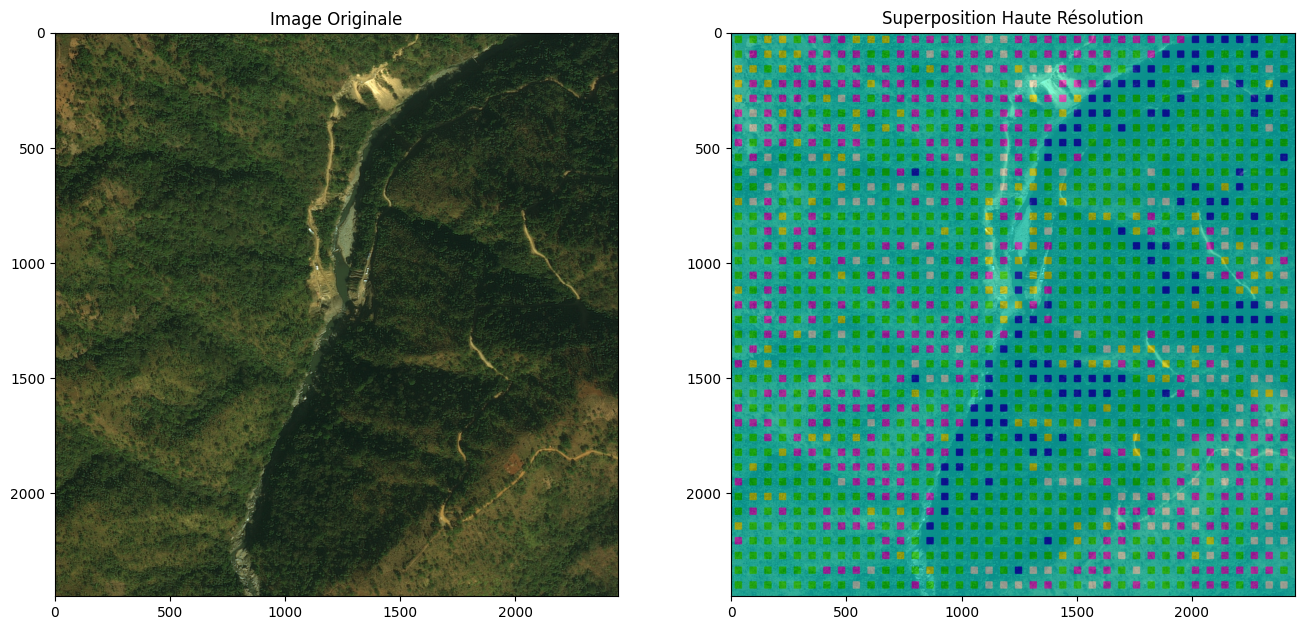

In [9]:
import os
import joblib
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

# --- 1. Vos variables (définies au début) ---
image_path = '/kaggle/input/deepglobe-land-cover-classification-dataset/test/668404_sat.jpg'

# ATTENTION : Vérifiez le nom exact de votre modèle sauvegardé précédemment 
# (xgboost_model.pkl ou xgboost_best_model.pkl ?)
model_path = '/kaggle/working/xgboost_model.pkl' 
scaler_path = '/kaggle/working/scaler.pkl'

# --- 2. La fonction (Votre code) ---
def predict_image_smooth(image_path, model_path, scaler_path):
    print(f"--- Traitement Haute Qualité : {os.path.basename(image_path)} ---")
    
    # Chargement
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    extractor = OptimizedFeatureExtractor() # Assurez-vous que cette classe est définie
    
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w = img.shape[:2]
    
    patch_size = 64
    stride = 64
    
    prediction_map = np.zeros((h, w), dtype=np.uint8)
    
    print("Scan en cours (ceci sera plus long)...")
    
    patches = []
    coords = []
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(extractor.extract(patch))
            coords.append((y, x))
            
    if len(patches) > 0:
        X_new = np.nan_to_num(np.array(patches))
        X_scaled = scaler.transform(X_new)
        preds = model.predict(X_scaled)
        
        for (y, x), label in zip(coords, preds):
            y_start = y + patch_size//4
            y_end = y + 3*patch_size//4
            x_start = x + patch_size//4
            x_end = x + 3*patch_size//4
            prediction_map[y_start:y_end, x_start:x_end] = label

    clean_map = median_filter(prediction_map, size=5)
    return img, clean_map

# --- 3. TEST CORRIGÉ ---
# Correction : on utilise 'image_path' au lieu de 'test_image_path'
# Correction : on passe les variables model_path et scaler_path qui contiennent les chemins complets
try:
    img, pred_smooth = predict_image_smooth(image_path, model_path, scaler_path)

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img)
    axes[0].set_title("Image Originale")

    # Coloriage (Assurez-vous que LABEL_TO_COLOR est défini)
    mask_vis = np.zeros((pred_smooth.shape[0], pred_smooth.shape[1], 3), dtype=np.uint8)
    if 'LABEL_TO_COLOR' in globals():
        for label, color in LABEL_TO_COLOR.items():
            mask_vis[pred_smooth == label] = color
    else:
        print("Attention : LABEL_TO_COLOR non défini, affichage en niveaux de gris")
        mask_vis = pred_smooth

    axes[1].imshow(img)
    axes[1].imshow(mask_vis, alpha=0.5)
    axes[1].set_title("Superposition Haute Résolution")
    plt.show()

except FileNotFoundError as e:
    print(f"ERREUR DE FICHIER : {e}")
    print("Vérifiez que vous avez bien sauvegardé le modèle sous le nom 'xgboost_best_model.pkl'")

--- Traitement OPTIMISÉ (Rapide) : 668404_sat.jpg ---
Découpage de l'image...
Extraction des features sur 5625 patchs en parallèle...
Reconstruction de la carte...
Temps total d'exécution : 48.68 secondes


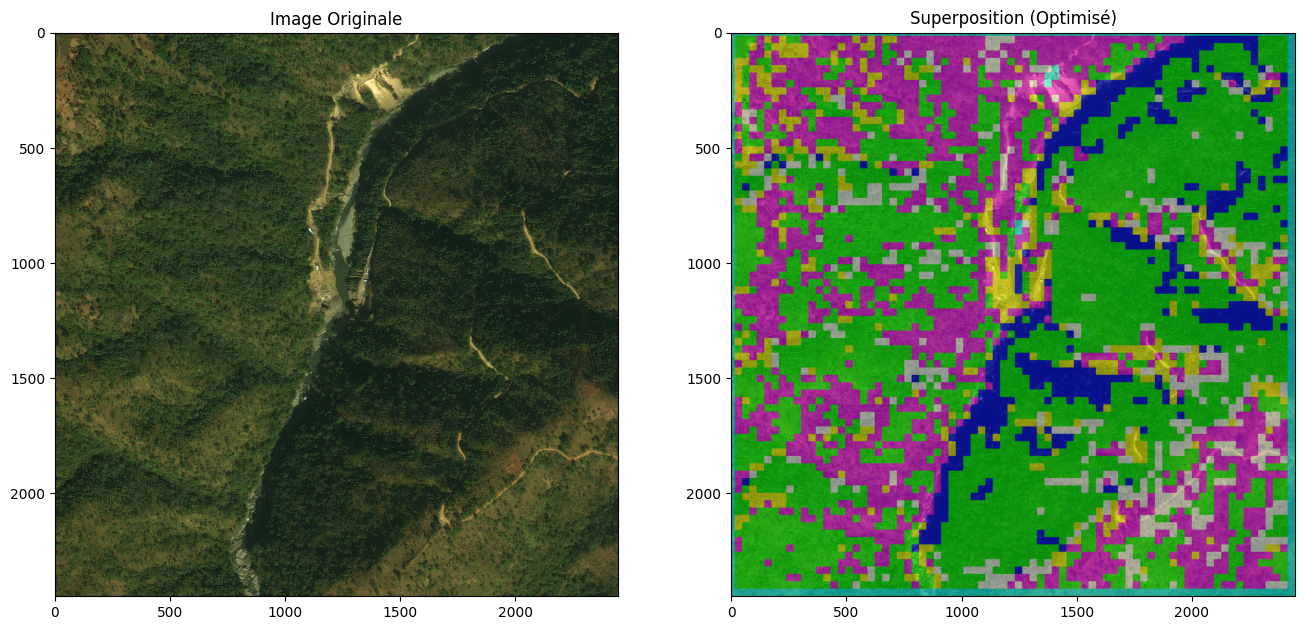

In [10]:
import os
import joblib
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.util import view_as_windows  # <--- Bibliothèque clé pour la vitesse
from joblib import Parallel, delayed      # <--- Pour utiliser tous les coeurs CPU

# --- Vos chemins (identiques) ---
image_path = '/kaggle/input/deepglobe-land-cover-classification-dataset/test/668404_sat.jpg'
model_path = '/kaggle/working/xgboost_model.pkl' 
scaler_path = '/kaggle/working/scaler.pkl'

def predict_image_optimized(image_path, model_path, scaler_path):
    print(f"--- Traitement OPTIMISÉ (Rapide) : {os.path.basename(image_path)} ---")
    
    # 1. Chargement
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    extractor = OptimizedFeatureExtractor() 
    
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w = img.shape[:2]
    
    # Paramètres
    patch_size = 64
    stride = 32
    
    # 2. Extraction vectorisée des patchs (Instantané vs Boucle for)
    # Cela crée une vue de forme (n_lignes, n_cols, 1, 64, 64, 3)
    print("Découpage de l'image...")
    patches_window = view_as_windows(img, (patch_size, patch_size, 3), step=stride)
    
    # On récupère les dimensions de la grille de patchs
    n_rows, n_cols = patches_window.shape[:2]
    
    # Aplatir pour avoir une liste de tous les patchs : (N_patchs, 64, 64, 3)
    flat_patches = patches_window.reshape(-1, patch_size, patch_size, 3)
    
    print(f"Extraction des features sur {len(flat_patches)} patchs en parallèle...")
    
    # 3. Extraction Parallèle (C'est ici que l'on gagne le plus de temps)
    # n_jobs=-1 utilise tous les processeurs disponibles
    features_list = Parallel(n_jobs=-1, prefer="threads")(
        delayed(extractor.extract)(patch) for patch in flat_patches
    )
    
    # 4. Prédiction en Batch
    X_new = np.nan_to_num(np.array(features_list))
    X_scaled = scaler.transform(X_new)
    preds = model.predict(X_scaled)
    
    # 5. Reconstruction rapide de la carte
    # On remet les prédictions sous forme de grille (lignes, colonnes)
    preds_grid = preds.reshape(n_rows, n_cols)
    
    prediction_map = np.zeros((h, w), dtype=np.uint8)
    
    print("Reconstruction de la carte...")
    # On itère sur la grille (beaucoup moins d'itérations que les pixels)
    for i in range(n_rows):
        for j in range(n_cols):
            # Calcul des coordonnées pixels
            y = i * stride
            x = j * stride
            label = preds_grid[i, j]
            
            # Remplissage du centre (logique identique à avant)
            y_start = y + patch_size//4
            y_end = y + 3*patch_size//4
            x_start = x + patch_size//4
            x_end = x + 3*patch_size//4
            
            # Gestion des bords pour ne pas dépasser
            if y_end > h: y_end = h
            if x_end > w: x_end = w
            
            prediction_map[y_start:y_end, x_start:x_end] = label

    # Lissage final
    clean_map = median_filter(prediction_map, size=5)
    return img, clean_map

# --- EXECUTION DU CODE OPTIMISÉ ---
try:
    import time
    start_time = time.time()
    
    img, pred_smooth = predict_image_optimized(image_path, model_path, scaler_path)
    
    end_time = time.time()
    print(f"Temps total d'exécution : {end_time - start_time:.2f} secondes")

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img)
    axes[0].set_title("Image Originale")

    mask_vis = np.zeros((pred_smooth.shape[0], pred_smooth.shape[1], 3), dtype=np.uint8)
    if 'LABEL_TO_COLOR' in globals():
        for label, color in LABEL_TO_COLOR.items():
            mask_vis[pred_smooth == label] = color
    else:
        mask_vis = pred_smooth # Fallback

    axes[1].imshow(img)
    axes[1].imshow(mask_vis, alpha=0.5)
    axes[1].set_title("Superposition (Optimisé)")
    plt.show()

except Exception as e:
    print(f"Erreur : {e}")

--- 🚀 Traitement ULTRA RAPIDE : 108490_sat.jpg ---
1. Découpage matriciel...
2. Extraction features sur 5625 patchs (Parallélisé)...
3. Reconstruction instantanée...
4. Lissage final...

✅ Terminé en : 7.15 secondes


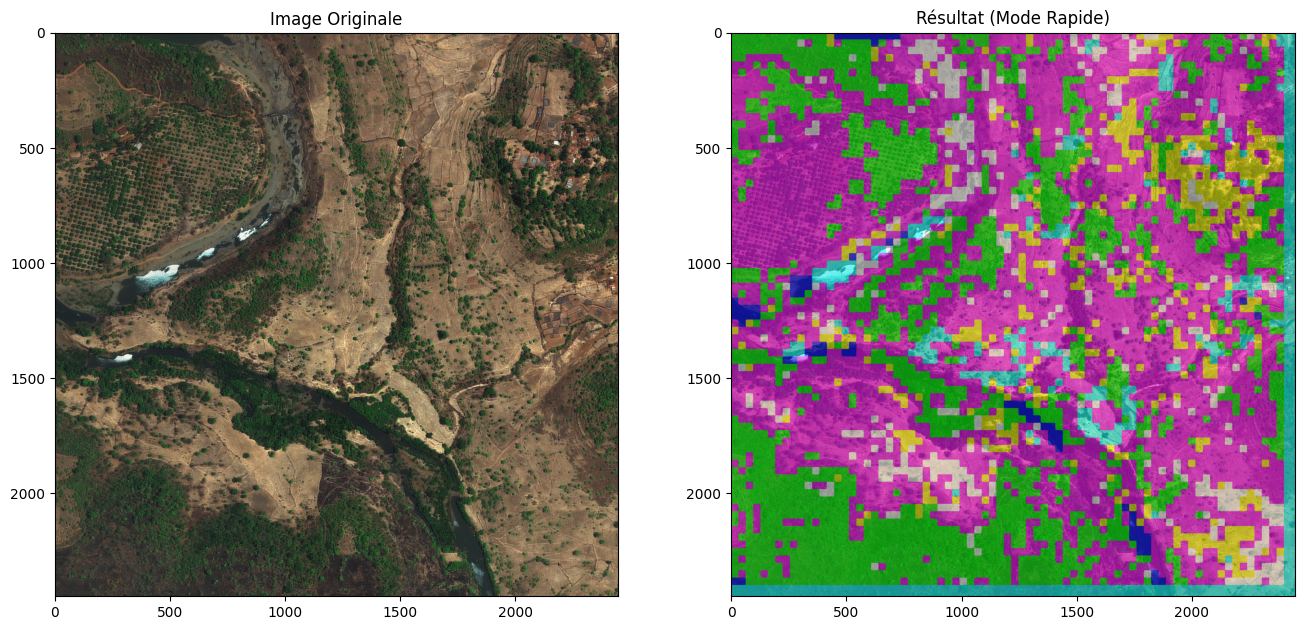

In [11]:
import os
import joblib
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.util import view_as_windows
from joblib import Parallel, delayed

# --- Vos chemins ---
image_path = '/kaggle/input/deepglobe-land-cover-classification-dataset/valid/108490_sat.jpg'
model_path = '/kaggle/working/xgboost_model.pkl' 
scaler_path = '/kaggle/working/scaler.pkl'

def predict_image_ultra_fast(image_path, model_path, scaler_path):
    print(f"--- 🚀 Traitement ULTRA RAPIDE : {os.path.basename(image_path)} ---")
    
    # 1. Chargement (Identique)
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    extractor = OptimizedFeatureExtractor() 
    
    # Lecture image
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w = img.shape[:2]
    
    # --- PARAMÈTRE DE VITESSE ---
    # Augmentez 'stride' pour aller plus vite.
    # stride = 64 -> TRÈS RAPIDE (mais un peu carré)
    # stride = 32 -> Compromis (votre choix actuel)
    patch_size = 64
    stride = 32  
    
    # 2. Découpage instantané (View)
    print("1. Découpage matriciel...")
    # On force une division entière pour éviter les erreurs de dimension
    patches_window = view_as_windows(img, (patch_size, patch_size, 3), step=stride)
    n_rows, n_cols = patches_window.shape[:2]
    
    # Aplatir sans copier si possible (reshape)
    flat_patches = patches_window.reshape(-1, patch_size, patch_size, 3)
    n_patches = flat_patches.shape[0]
    
    print(f"2. Extraction features sur {n_patches} patchs (Parallélisé)...")
    
    # 3. Parallélisation Optimisée
    # 'batch_size="auto"' permet d'envoyer les tâches par paquets aux processeurs
    # cela réduit l'overhead (le temps perdu à lancer les processus)
    features_list = Parallel(n_jobs=-1, batch_size='auto')(
        delayed(extractor.extract)(patch) for patch in flat_patches
    )
    
    # 4. Prédiction Batch (rapide)
    X_new = np.nan_to_num(np.array(features_list))
    X_scaled = scaler.transform(X_new)
    preds = model.predict(X_scaled)
    
    # 5. Reconstruction VECTORISÉE (C'est ici qu'on gagne 90% du temps final)
    print("3. Reconstruction instantanée...")
    
    # On remet les prédictions sous forme de grille (ex: 30x30 cases)
    preds_grid = preds.reshape(n_rows, n_cols)
    
    # Au lieu de faire des boucles, on "étire" chaque prédiction pour faire un carré de taille 'stride'
    # np.repeat répète les valeurs pour remplir les pixels
    # C'est INSTANTANÉ comparé à la boucle for
    map_temp = preds_grid.repeat(stride, axis=0).repeat(stride, axis=1)
    
    # Création de la carte finale de la bonne taille
    prediction_map = np.zeros((h, w), dtype=np.uint8)
    
    # On place la carte étirée dans l'image (en gérant les bords)
    h_fill = min(h, map_temp.shape[0])
    w_fill = min(w, map_temp.shape[1])
    prediction_map[:h_fill, :w_fill] = map_temp[:h_fill, :w_fill]

    # 6. Lissage (indispensable car la reconstruction vectorisée fait des blocs)
    print("4. Lissage final...")
    clean_map = median_filter(prediction_map, size=7) # Taille 7 pour bien lisser les blocs
    
    return img, clean_map

# --- EXECUTION ---
try:
    import time
    start_time = time.time()
    
    # Appel de la fonction optimisée
    img, pred_smooth = predict_image_ultra_fast(image_path, model_path, scaler_path)
    
    end_time = time.time()
    print(f"\n✅ Terminé en : {end_time - start_time:.2f} secondes")

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img)
    axes[0].set_title("Image Originale")

    # Gestion des couleurs
    mask_vis = np.zeros((pred_smooth.shape[0], pred_smooth.shape[1], 3), dtype=np.uint8)
    if 'LABEL_TO_COLOR' in globals():
        for label, color in LABEL_TO_COLOR.items():
            mask_vis[pred_smooth == label] = color
    else:
        mask_vis = pred_smooth 

    axes[1].imshow(img)
    axes[1].imshow(mask_vis, alpha=0.5)
    axes[1].set_title("Résultat (Mode Rapide)")
    plt.show()

except Exception as e:
    import traceback
    traceback.print_exc()
    print(f"Erreur : {e}")

=== RAPPORT DE CLASSIFICATION DE L'IMAGE ===
Classe          | Pixels     | Pourcentage
---------------------------------------------
urban           | 426339     | 7.11%
agriculture     | 444794     | 7.42%
rangeland       | 3129260    | 52.22%
forest          | 1554037    | 25.93%
water           | 75656      | 1.26%
barren          | 362618     | 6.05%


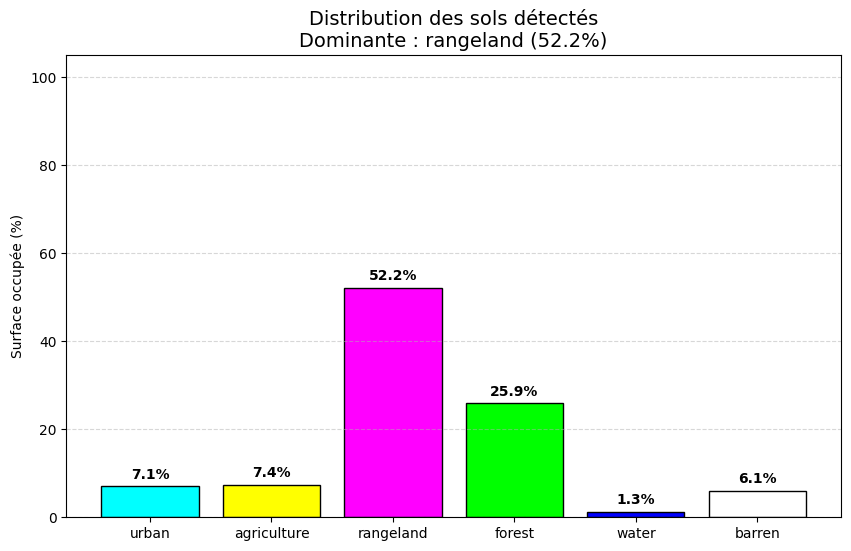

In [12]:
# --------------------- ANALYSE DU RÉSULTAT ---------------------
import pandas as pd
import matplotlib.pyplot as plt

def analyze_prediction(prediction_map):
    total_pixels = prediction_map.size
    unique, counts = np.unique(prediction_map, return_counts=True)
    
    # Création d'un dictionnaire pour stocker les résultats
    stats = []
    
    print("=== RAPPORT DE CLASSIFICATION DE L'IMAGE ===")
    print(f"{'Classe':<15} | {'Pixels':<10} | {'Pourcentage':<10}")
    print("-" * 45)
    
    # On parcourt toutes les classes possibles (0 à 5)
    for label_id in range(len(CLASS_NAMES)):
        class_name = CLASS_NAMES[label_id]
        
        # On récupère le compte (0 si la classe n'est pas présente)
        if label_id in unique:
            idx = np.where(unique == label_id)[0][0]
            count = counts[idx]
        else:
            count = 0
            
        percentage = (count / total_pixels) * 100
        stats.append({
            'Label': label_id,
            'Classe': class_name,
            'Pourcentage': percentage,
            'Color': [c/255.0 for c in LABEL_TO_COLOR[label_id]] # Normalisation couleur pour matplotlib
        })
        
        print(f"{class_name:<15} | {count:<10} | {percentage:.2f}%")

    # Conversion en DataFrame pour manipulation facile
    df_stats = pd.DataFrame(stats)
    
    # --- VISUALISATION GRAPHIQUE ---
    plt.figure(figsize=(10, 6))
    
    # Création du bar chart avec les bonnes couleurs
    bars = plt.bar(df_stats['Classe'], df_stats['Pourcentage'], color=df_stats['Color'], edgecolor='black')
    
    # Ajout des étiquettes de pourcentage au-dessus des barres
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Classe dominante
    dominant_class = df_stats.loc[df_stats['Pourcentage'].idxmax(), 'Classe']
    dominant_pct = df_stats['Pourcentage'].max()

    plt.title(f"Distribution des sols détectés\nDominante : {dominant_class} ({dominant_pct:.1f}%)", fontsize=14)
    plt.ylabel("Surface occupée (%)")
    plt.ylim(0, 105) # Pour laisser de la place au texte
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return df_stats

# Exécution de l'analyse sur le résultat lissé
df_resultats = analyze_prediction(pred_smooth)